In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import os
from scipy.stats import sem
from matplotlib.lines import Line2D
import sys
sys.path.append("../../behavior")
import boris_extraction as boris
import pickle

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

In [2]:
boris_data_path = r"C:\Users\megha\Documents\Padilla-Coreano\homecage_social_ephys_vids\pilot2\boris\habit_dishabit_aggregated\*"
file_paths = glob.glob(boris_data_path)

In [3]:
#each recording is aprox. 36 min long except
#21_nov and 31_nov are at double speed


#each recording has 5 ins and 4 outs except 22_nov and 32_cage
#22_nov = mice_in_df[3], mouse_out[2] is a jump period 
#32_cage last exposure starts ay 31min 26 sec and A4 ends at 31 min and 11 seconds


# for everyone including 32_cage
# baseline = 0 - mouse_in[0]
# A1 = mouse_in[0] - mouse_out[0]
# A2 = mouse_in[1] - mouse_out[1]
# A3 = mouse_in[2] - mouse_out[2]
# A4 = mouse_in[3] - mouse_out[3]
# b1 = mouse_in[4] - end

#22_nov 
# baseline = 0 - mouse_in[0]
# A1 = mouse_in[0] - mouse_out[0]
# A2 = mouse_in[1] - mouse_out[1]
# A3 = mouse_in[2] - mouse_out[3]
# jump = mouse_out[2] - mouse_in[3]
# A4 = mouse_in[4] - mouse_out[4]
# b1 = mouse_in[5] - end




In [4]:
dictOfBoris={}
df_list =[]
for file_path in file_paths:
    if file_path.endswith('.csv'):
        phase1_df = pd.read_csv(file_path)
    elif file_path.endswith('.tsv'):
        phase1_df = pd.read_csv(file_path, sep='\t')
    df_list.append(phase1_df)
    phase1_df.name = file_path
    filename_no_ext = os.path.splitext(os.path.basename(file_path))[0]
    dictOfBoris[filename_no_ext] = phase1_df

In [5]:
# filename = df 

# behavior = ['anogenital sniffing', 'facial sniffing']
# subject = ['subject']
# min ITI = 1 
# min bout = 0.5

#for df create a list of mouse in and out times
#for df call boris_extract fxn which will give an array of start and stop times 
#then trim array by mouse in and mouse out times 


In [6]:

# for everyone including 32_cage
# baseline = 0 - mouse_in[0]
# A1 = mouse_in[0] - mouse_out[0]
# A2 = mouse_in[1] - mouse_out[1]
# A3 = mouse_in[2] - mouse_out[2]
# A4 = mouse_in[3] - mouse_out[3]
# b1 = mouse_in[4] - end

#22_nov 
# baseline = 0 - mouse_in[0]
# A1 = mouse_in[0] - mouse_out[0]
# A2 = mouse_in[1] - mouse_out[1]
# A3 = mouse_in[2] - mouse_out[3]
# jump = mouse_out[2] - mouse_in[3]
# A4 = mouse_in[4] - mouse_out[4]
# b1 = mouse_in[5] - end


In [7]:
behavior = ['anogenital sniffing', 'facial sniffing']
subject = ['subject']
min_iti = 1 
min_bout = 0.5

behavior_dicts = {}
cage_dicts = {}
novel_dicts = {}
for recording, df in dictOfBoris.items():
    behavior_dict = {}
    mouse_in = np.array(df[df['Behavior'] == 'mice back in']['Start (s)'].tolist())*1000
    mouse_out = np.array(df[df['Behavior'] == 'mice taken out']['Start (s)'].tolist())*1000
    sniffs = boris.get_behavior_bouts(df, subject, behavior, min_iti, min_bout)
    if (recording == '21_nov_p1_aggregated') | (recording == '31_nov_p1_aggregated'):
        sniffs = np.array([[x*2 for x in sniff] for sniff in sniffs])
        mouse_in = mouse_in *2
        mouse_out = mouse_out*2 
    if recording == '22_nov_p1_aggregated':
        behavior_dict['exp1'] = sniffs[(sniffs[:,0] > mouse_in[0]) & (sniffs[:,1] < mouse_out[0])]
        behavior_dict['exp2'] = sniffs[(sniffs[:,0] > mouse_in[1]) & (sniffs[:,1] < mouse_out[1])]
        behavior_dict['exp3'] = sniffs[(sniffs[:,0] > mouse_in[2]) & (sniffs[:,1] < mouse_out[3])]
        behavior_dict['exp4'] = sniffs[(sniffs[:,0] > mouse_in[4]) & (sniffs[:,1] < mouse_out[4])]
        behavior_dict['exp5'] = sniffs[(sniffs[:,0] > mouse_in[5])]
    else: 
        behavior_dict['exp1'] = sniffs[(sniffs[:,0] > mouse_in[0]) & (sniffs[:,1] < mouse_out[0])]
        behavior_dict['exp2'] = sniffs[(sniffs[:,0] > mouse_in[1]) & (sniffs[:,1] < mouse_out[1])]
        behavior_dict['exp3'] = sniffs[(sniffs[:,0] > mouse_in[2]) & (sniffs[:,1] < mouse_out[2])]
        behavior_dict['exp4'] = sniffs[(sniffs[:,0] > mouse_in[3]) & (sniffs[:,1] < mouse_out[3])]
        behavior_dict['exp5'] = sniffs[(sniffs[:,0] > mouse_in[4])]
    
    behavior_dicts[recording] = behavior_dict
    if "cage" in recording:
        cage_dicts[recording] = behavior_dict
    else:
        novel_dicts[recording] = behavior_dict

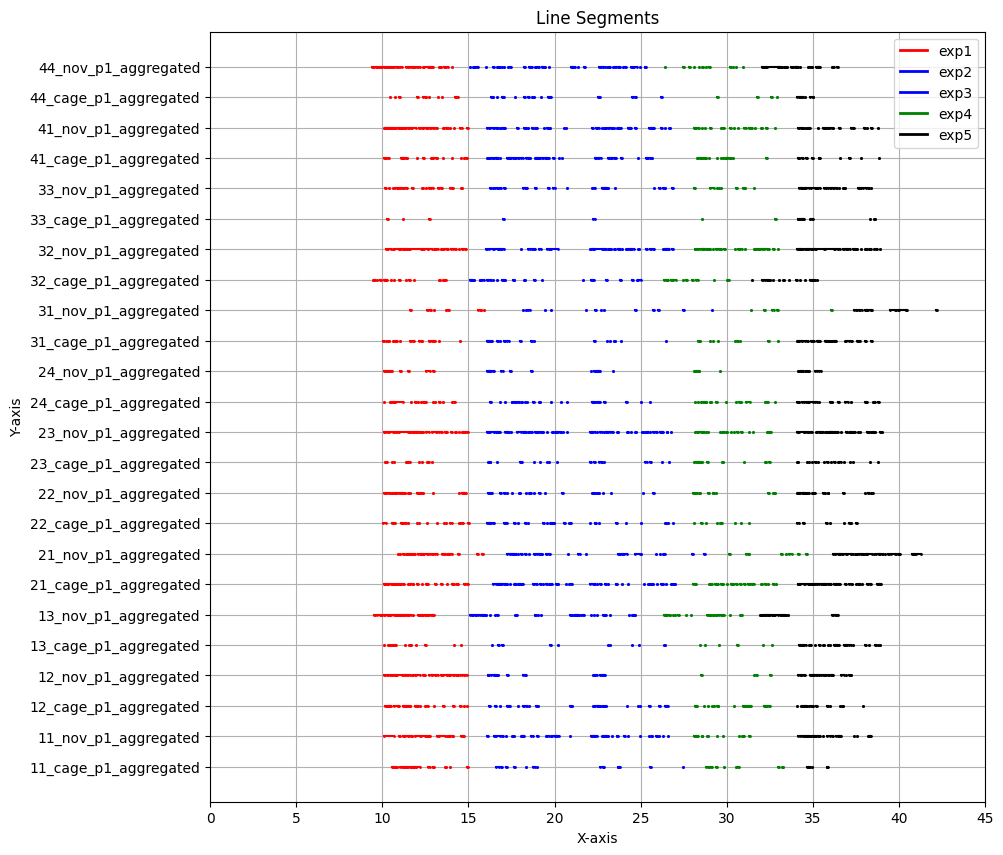

In [8]:
color_dict = {'exp1': 'r', 'exp2': 'b', 'exp3': 'b', 'exp4': 'g',
              'exp5' : 'k'}
recording_number = 0
plt.figure(figsize = (10,10))
labels = []
for name, recording in behavior_dicts.items():
    labels.append(name)
    for event, snippets in recording.items():
        if (event =='exp1'
            ) | (event == 'exp2'
                 ) | (event == 'exp3'
                      ) | (event == 'exp4'
                    ) | (event == 'exp5'):
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event], markersize = 1)
    recording_number += .5
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.yticks(ticks=np.arange(len(labels))/2, labels=labels)
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,45])
plt.show()

# All condition

In [9]:
event_info = {}
sniff_itis = []
j = 0
total_sniffs = 0
subject_info = {}
for subject, behavior_dict in behavior_dicts.items():
    event_dict_keys = behavior_dict.keys()
    for event, events in behavior_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            sniff_length_temp = events[i][1] - events[i][0]
            sniff_length = sniff_length + sniff_length_temp
            total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        try:
            avg_event = sniff_length/no_events/1000
        except ZeroDivisionError:
            avg_event = 0
        if subject in event_info.keys():
            dict_event = event_info[subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[subject] =  dict_event
        else:
            event_info[subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
    j += 1
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 1:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # was 54 with old thresholding for less than 2, 142 for 5
print(total_sniffs)
print(event_info)

event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_dict_keys
event_overview
event_temp = event_overview.drop('level_0', axis = 1)
event_overview_averages = event_temp.groupby('level_1').mean()
event_overview_averages



0
1963
{'11_cage_p1_aggregated': {'exp1': {'no_events': 21, 'avg event': 3.0222857142857142, 'total time': 63.468}, 'exp2': {'no_events': 7, 'avg event': 3.866714285714302, 'total time': 27.067000000000117}, 'exp3': {'no_events': 7, 'avg event': 2.5044285714285714, 'total time': 17.531}, 'exp4': {'no_events': 10, 'avg event': 1.8069000000000002, 'total time': 18.069}, 'exp5': {'no_events': 5, 'avg event': 2.5065999999999997, 'total time': 12.533}}, '11_nov_p1_aggregated': {'exp1': {'no_events': 20, 'avg event': 8.1506, 'total time': 163.012}, 'exp2': {'no_events': 20, 'avg event': 3.7233500000000057, 'total time': 74.46700000000011}, 'exp3': {'no_events': 23, 'avg event': 1.953608695652174, 'total time': 44.933}, 'exp4': {'no_events': 13, 'avg event': 1.630923076923077, 'total time': 21.202}, 'exp5': {'no_events': 23, 'avg event': 2.7391304347825884, 'total time': 62.99999999999953}}, '12_cage_p1_aggregated': {'exp1': {'no_events': 24, 'avg event': 2.3194166666666667, 'total time': 55.

,exp1,exp2,exp3,exp4,exp5
level_1,,,,,
avg event,3.335243,2.534004,2.324000,2.236234,3.270312
no_events,20.541667,15.875000,13.458333,12.625000,19.291667
total time,72.391292,39.611083,29.224250,27.691708,64.367125


In [10]:
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_agent_time_averages = {}
avg_events = []
sem_events = []
for event in event_dict_keys:
    if 'cup' not in event:
        avg_event = event_total_time[event].mean()
        sem_event = sem(event_total_time[event])
        event_agent_time_averages[event] = avg_event
        avg_events.append(avg_event)
        sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_agent_time_averages

{'exp1': 72.39129166666667,
 'exp2': 39.61108333333332,
 'exp3': 29.22425,
 'exp4': 27.691708333333324,
 'exp5': 64.36712500000003}

In [11]:
data_points = []
subjects = []
behaviors = []
for subject, dict in event_info.items():
    #iterating through subject
    event_list = []
    subjects.append(subject)
    for event, times in dict.items():
        #iterating through event
        event_list.append(times['total time'])
        behaviors.append(event)
    data_points.append(event_list)
data_points = np.array(data_points).T
print(subjects)
print(behaviors[0:5])
print(data_points.shape)
print(data_points.shape)

['11_cage_p1_aggregated', '11_nov_p1_aggregated', '12_cage_p1_aggregated', '12_nov_p1_aggregated', '13_cage_p1_aggregated', '13_nov_p1_aggregated', '21_cage_p1_aggregated', '21_nov_p1_aggregated', '22_cage_p1_aggregated', '22_nov_p1_aggregated', '23_cage_p1_aggregated', '23_nov_p1_aggregated', '24_cage_p1_aggregated', '24_nov_p1_aggregated', '31_cage_p1_aggregated', '31_nov_p1_aggregated', '32_cage_p1_aggregated', '32_nov_p1_aggregated', '33_cage_p1_aggregated', '33_nov_p1_aggregated', '41_cage_p1_aggregated', '41_nov_p1_aggregated', '44_cage_p1_aggregated', '44_nov_p1_aggregated']
['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
(5, 24)
(5, 24)


['11_cage_p1_aggregated', '11_nov_p1_aggregated', '12_cage_p1_aggregated', '12_nov_p1_aggregated', '13_cage_p1_aggregated', '13_nov_p1_aggregated', '21_cage_p1_aggregated', '21_nov_p1_aggregated', '22_cage_p1_aggregated', '22_nov_p1_aggregated', '23_cage_p1_aggregated', '23_nov_p1_aggregated', '24_cage_p1_aggregated', '24_nov_p1_aggregated', '31_cage_p1_aggregated', '31_nov_p1_aggregated', '32_cage_p1_aggregated', '32_nov_p1_aggregated', '33_cage_p1_aggregated', '33_nov_p1_aggregated', '41_cage_p1_aggregated', '41_nov_p1_aggregated', '44_cage_p1_aggregated', '44_nov_p1_aggregated']


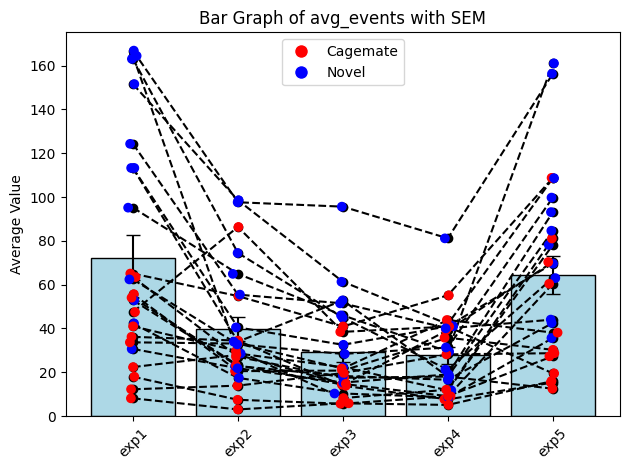

In [12]:
print(subjects)
x = np.arange(len(avg_events))
labels = event_agent_time_averages.keys()
# Create the bar plot
plt.bar(x, avg_events, yerr=sem_events, capsize=5, color='lightblue', edgecolor='black')
for i, group_data in enumerate(data_points):
    jitter = np.random.normal(0, 0.02, size=len(group_data))
    
    # Create separate colors for each subject based on pattern
    colors = ['red' if 'cage' in str(subject).lower() else 
              'blue' if 'nov' in str(subject).lower() else 
              'gray' for subject in subjects]
    
    plt.scatter([i + jitter_val for jitter_val in jitter], 
                group_data, 
                color=colors, 
                zorder=5)
for j in range(len(data_points[0])):  # Assuming all groups have the same number of data points
    x_vals = np.arange(len(data_points))  # X positions for all groups
    y_vals = [data_points[i][j] for i in range(len(data_points))]  # Y values for the same index
    plt.plot(x_vals, y_vals, color='black', linestyle='--', marker='o', zorder=4)

legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor='red', label='Cagemate', markersize=10),
                  Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor='blue', label='Novel', markersize=10)]

# Add the legend
plt.legend(handles=legend_elements)
# Add labels and title
plt.xticks(x, labels, rotation = 45)
plt.ylabel('Average Value')
plt.title('Bar Graph of avg_events with SEM')

# Show the plot
plt.tight_layout()
plt.show()


# Cagemate data

In [13]:
event_info = {}
sniff_itis = []
j = 0
total_sniffs = 0
subject_info = {}
for subject, behavior_dict in cage_dicts.items():
    event_dict_keys = behavior_dict.keys()
    for event, events in behavior_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            sniff_length_temp = events[i][1] - events[i][0]
            sniff_length = sniff_length + sniff_length_temp
            total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        try:
            avg_event = sniff_length/no_events/1000
        except ZeroDivisionError:
            avg_event = 0
        if subject in event_info.keys():
            dict_event = event_info[subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[subject] =  dict_event
        else:
            event_info[subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
    j += 1
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 1:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # was 54 with old thresholding for less than 2, 142 for 5
print(total_sniffs)
print(event_info)

event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_dict_keys
event_overview
event_temp = event_overview.drop('level_0', axis = 1)
event_overview_averages = event_temp.groupby('level_1').mean()
event_overview_averages



0
840
{'11_cage_p1_aggregated': {'exp1': {'no_events': 21, 'avg event': 3.0222857142857142, 'total time': 63.468}, 'exp2': {'no_events': 7, 'avg event': 3.866714285714302, 'total time': 27.067000000000117}, 'exp3': {'no_events': 7, 'avg event': 2.5044285714285714, 'total time': 17.531}, 'exp4': {'no_events': 10, 'avg event': 1.8069000000000002, 'total time': 18.069}, 'exp5': {'no_events': 5, 'avg event': 2.5065999999999997, 'total time': 12.533}}, '12_cage_p1_aggregated': {'exp1': {'no_events': 24, 'avg event': 2.3194166666666667, 'total time': 55.666}, 'exp2': {'no_events': 13, 'avg event': 1.5794615384615385, 'total time': 20.533}, 'exp3': {'no_events': 16, 'avg event': 1.3, 'total time': 20.8}, 'exp4': {'no_events': 19, 'avg event': 1.8841052631578947, 'total time': 35.798}, 'exp5': {'no_events': 16, 'avg event': 1.8916249999999855, 'total time': 30.265999999999767}}, '13_cage_p1_aggregated': {'exp1': {'no_events': 15, 'avg event': 1.2002000000000002, 'total time': 18.003}, 'exp2': 

,exp1,exp2,exp3,exp4,exp5
level_1,,,,,
avg event,2.178756,2.085282,2.258632,2.086299,2.575600
no_events,17.333333,15.000000,9.750000,11.916667,16.000000
total time,38.124333,30.137917,18.495750,25.355917,42.371667


In [14]:
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_agent_time_averages = {}
avg_events = []
sem_events = []
for event in event_dict_keys:
    if 'cup' not in event:
        avg_event = event_total_time[event].mean()
        sem_event = sem(event_total_time[event])
        event_agent_time_averages[event] = avg_event
        avg_events.append(avg_event)
        sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_agent_time_averages

{'exp1': 38.12433333333333,
 'exp2': 30.13791666666663,
 'exp3': 18.495750000000005,
 'exp4': 25.35591666666667,
 'exp5': 42.371666666666705}

In [15]:
data_points = []
subjects = []
behaviors = []
for subject, dict in event_info.items():
    #iterating through subject
    event_list = []
    subjects.append(subject)
    for event, times in dict.items():
        #iterating through event
        event_list.append(times['total time'])
        behaviors.append(event)
    data_points.append(event_list)
data_points = np.array(data_points).T
print(subjects)
print(behaviors[0:5])
print(data_points.shape)
print(data_points.shape)

['11_cage_p1_aggregated', '12_cage_p1_aggregated', '13_cage_p1_aggregated', '21_cage_p1_aggregated', '22_cage_p1_aggregated', '23_cage_p1_aggregated', '24_cage_p1_aggregated', '31_cage_p1_aggregated', '32_cage_p1_aggregated', '33_cage_p1_aggregated', '41_cage_p1_aggregated', '44_cage_p1_aggregated']
['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
(5, 12)
(5, 12)


['11_cage_p1_aggregated', '12_cage_p1_aggregated', '13_cage_p1_aggregated', '21_cage_p1_aggregated', '22_cage_p1_aggregated', '23_cage_p1_aggregated', '24_cage_p1_aggregated', '31_cage_p1_aggregated', '32_cage_p1_aggregated', '33_cage_p1_aggregated', '41_cage_p1_aggregated', '44_cage_p1_aggregated']


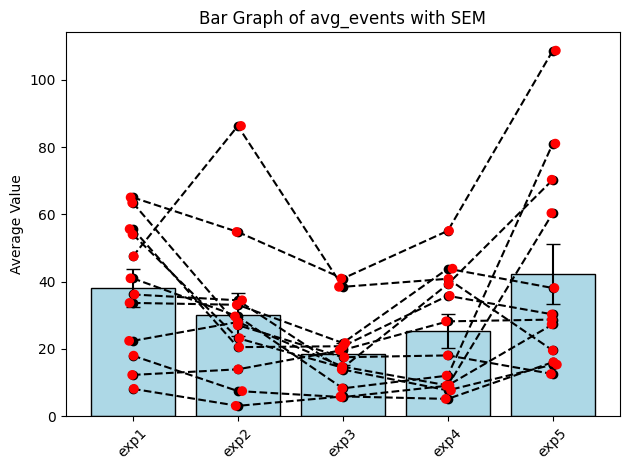

In [16]:
print(subjects)
x = np.arange(len(avg_events))
labels = event_agent_time_averages.keys()
# Create the bar plot
plt.bar(x, avg_events, yerr=sem_events, capsize=5, color='lightblue', edgecolor='black')
for i, group_data in enumerate(data_points):
    jitter = np.random.normal(0, 0.02, size=len(group_data))
    
    # Create separate colors for each subject based on pattern
    colors = ['red' if 'cage' in str(subject).lower() else 
              'blue' if 'nov' in str(subject).lower() else 
              'gray' for subject in subjects]
    
    plt.scatter([i + jitter_val for jitter_val in jitter], 
                group_data, 
                color=colors, 
                zorder=5)
for j in range(len(data_points[0])):  # Assuming all groups have the same number of data points
    x_vals = np.arange(len(data_points))  # X positions for all groups
    y_vals = [data_points[i][j] for i in range(len(data_points))]  # Y values for the same index
    plt.plot(x_vals, y_vals, color='black', linestyle='--', marker='o', zorder=4)

plt.xticks(x, labels, rotation = 45)
plt.ylabel('Average Value')
plt.title('Bar Graph of avg_events with SEM')

# Show the plot
plt.tight_layout()
plt.show()

# Novel data

In [17]:
event_info = {}
sniff_itis = []
j = 0
total_sniffs = 0
subject_info = {}
for subject, behavior_dict in novel_dicts.items():
    event_dict_keys = behavior_dict.keys()
    for event, events in behavior_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            sniff_length_temp = events[i][1] - events[i][0]
            sniff_length = sniff_length + sniff_length_temp
            total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        try:
            avg_event = sniff_length/no_events/1000
        except ZeroDivisionError:
            avg_event = 0
        if subject in event_info.keys():
            dict_event = event_info[subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[subject] =  dict_event
        else:
            event_info[subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
    j += 1
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 1:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # was 54 with old thresholding for less than 2, 142 for 5
print(total_sniffs)
print(event_info)

event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_dict_keys
event_overview
event_temp = event_overview.drop('level_0', axis = 1)
event_overview_averages = event_temp.groupby('level_1').mean()
event_overview_averages


0
1123
{'11_nov_p1_aggregated': {'exp1': {'no_events': 20, 'avg event': 8.1506, 'total time': 163.012}, 'exp2': {'no_events': 20, 'avg event': 3.7233500000000057, 'total time': 74.46700000000011}, 'exp3': {'no_events': 23, 'avg event': 1.953608695652174, 'total time': 44.933}, 'exp4': {'no_events': 13, 'avg event': 1.630923076923077, 'total time': 21.202}, 'exp5': {'no_events': 23, 'avg event': 2.7391304347825884, 'total time': 62.99999999999953}}, '12_nov_p1_aggregated': {'exp1': {'no_events': 28, 'avg event': 5.87125, 'total time': 164.395}, 'exp2': {'no_events': 10, 'avg event': 2.8601, 'total time': 28.601}, 'exp3': {'no_events': 7, 'avg event': 3.1904285714285714, 'total time': 22.333}, 'exp4': {'no_events': 4, 'avg event': 2.9495, 'total time': 11.798}, 'exp5': {'no_events': 19, 'avg event': 4.112263157894737, 'total time': 78.133}}, '13_nov_p1_aggregated': {'exp1': {'no_events': 27, 'avg event': 4.194407407407408, 'total time': 113.249}, 'exp2': {'no_events': 17, 'avg event': 2.

,exp1,exp2,exp3,exp4,exp5
level_1,,,,,
avg event,4.49173,2.982725,2.389368,2.386170,3.965023
no_events,23.75000,16.750000,17.166667,13.333333,22.583333
total time,106.65825,49.084250,39.952750,30.027500,86.362583


In [18]:
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_agent_time_averages = {}
avg_events = []
sem_events = []
for event in event_dict_keys:
    if 'cup' not in event:
        avg_event = event_total_time[event].mean()
        sem_event = sem(event_total_time[event])
        event_agent_time_averages[event] = avg_event
        avg_events.append(avg_event)
        sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_agent_time_averages

{'exp1': 106.65825000000001,
 'exp2': 49.084250000000026,
 'exp3': 39.95275,
 'exp4': 30.02749999999998,
 'exp5': 86.36258333333338}

In [19]:
data_points = []
subjects = []
behaviors = []
for subject, dict in event_info.items():
    #iterating through subject
    event_list = []
    subjects.append(subject)
    for event, times in dict.items():
        #iterating through event
        event_list.append(times['total time'])
        behaviors.append(event)
    data_points.append(event_list)
data_points = np.array(data_points).T
print(subjects)
print(behaviors[0:5])
print(data_points.shape)
print(data_points.shape)

['11_nov_p1_aggregated', '12_nov_p1_aggregated', '13_nov_p1_aggregated', '21_nov_p1_aggregated', '22_nov_p1_aggregated', '23_nov_p1_aggregated', '24_nov_p1_aggregated', '31_nov_p1_aggregated', '32_nov_p1_aggregated', '33_nov_p1_aggregated', '41_nov_p1_aggregated', '44_nov_p1_aggregated']
['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
(5, 12)
(5, 12)


['11_nov_p1_aggregated', '12_nov_p1_aggregated', '13_nov_p1_aggregated', '21_nov_p1_aggregated', '22_nov_p1_aggregated', '23_nov_p1_aggregated', '24_nov_p1_aggregated', '31_nov_p1_aggregated', '32_nov_p1_aggregated', '33_nov_p1_aggregated', '41_nov_p1_aggregated', '44_nov_p1_aggregated']


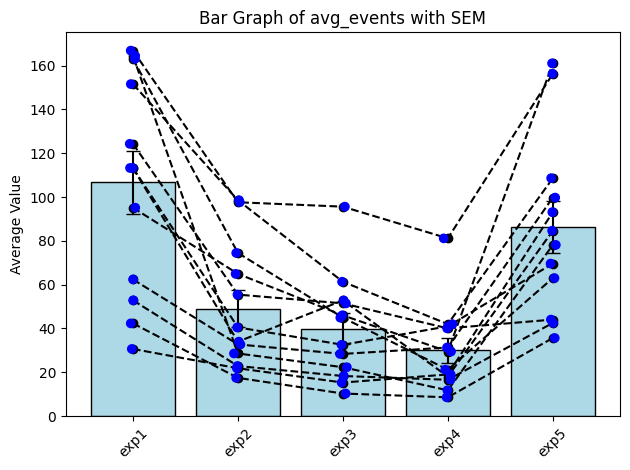

In [20]:
print(subjects)
x = np.arange(len(avg_events))
labels = event_agent_time_averages.keys()
# Create the bar plot
plt.bar(x, avg_events, yerr=sem_events, capsize=5, color='lightblue', edgecolor='black')
for i, group_data in enumerate(data_points):
    jitter = np.random.normal(0, 0.02, size=len(group_data))
    
    # Create separate colors for each subject based on pattern
    colors = ['red' if 'cage' in str(subject).lower() else 
              'blue' if 'nov' in str(subject).lower() else 
              'gray' for subject in subjects]
    
    plt.scatter([i + jitter_val for jitter_val in jitter], 
                group_data, 
                color=colors, 
                zorder=5)
for j in range(len(data_points[0])):  # Assuming all groups have the same number of data points
    x_vals = np.arange(len(data_points))  # X positions for all groups
    y_vals = [data_points[i][j] for i in range(len(data_points))]  # Y values for the same index
    plt.plot(x_vals, y_vals, color='black', linestyle='--', marker='o', zorder=4)


# Add labels and title
plt.xticks(x, labels, rotation = 45)
plt.ylabel('Average Value')
plt.title('Bar Graph of avg_events with SEM')

# Show the plot
plt.tight_layout()
plt.show()


In [21]:
pickle_this(behavior_dicts, "behavior_dicts.pkl")